In [1]:
import numbers
import numpy as np
from generalisedhyperbolic import GeneralisedHyperbolic
import matplotlib.pyplot as plt


In [2]:
# Plotting functions:

def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False, 
           rug_length=0.05, rug_kwargs=None, font_size=14, title_size=14, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=title_size) 
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
lam = -0.8
gamma = 0.1
delta = 1
beta = 0
sigma = 1
tol = 0.01
M_gamma = 10
M_stable = 100

In [4]:
simulator = GeneralisedHyperbolic(lam=lam, gamma=gamma, delta=delta, beta=beta, sigma=sigma, tolerance=tol, M_gamma=M_gamma, M_stable=M_stable)

The tolerance parameter of the adaptive truncation process is set to 0.01
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.


In [5]:
N = 500_000

point_process_samples = []
for _ in range(N):
    x_series = simulator.simulate_jumps()
    point_process_samples.append(x_series.sum())
point_process_samples = np.array(point_process_samples)

/Users/yaman/gh-levy-simulation/generalisedhyperbolic.py:30: RuntimeWarning: overflow encountered in exp
  return 1/(self.beta*(np.exp(gamma/self.C)-1))
/Users/yaman/gh-levy-simulation/generalisedhyperbolic.py:398: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)*incgammal(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)


In [16]:
samples_rv_sampler = simulator.random_sample(size=1_000_000)

range_min = point_process_samples.min()
range_max = point_process_samples.max()


if (np.abs(range_min) < np.abs(range_max)):
    range_max = np.abs(range_min)
else:
    range_min = -1*range_max

gh_range = np.linspace(range_min, range_max, 100000)
gh_density = simulator.probability_density(gh_range)

/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_49006/3305052145.py:56: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_49006/3305052145.py:57: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


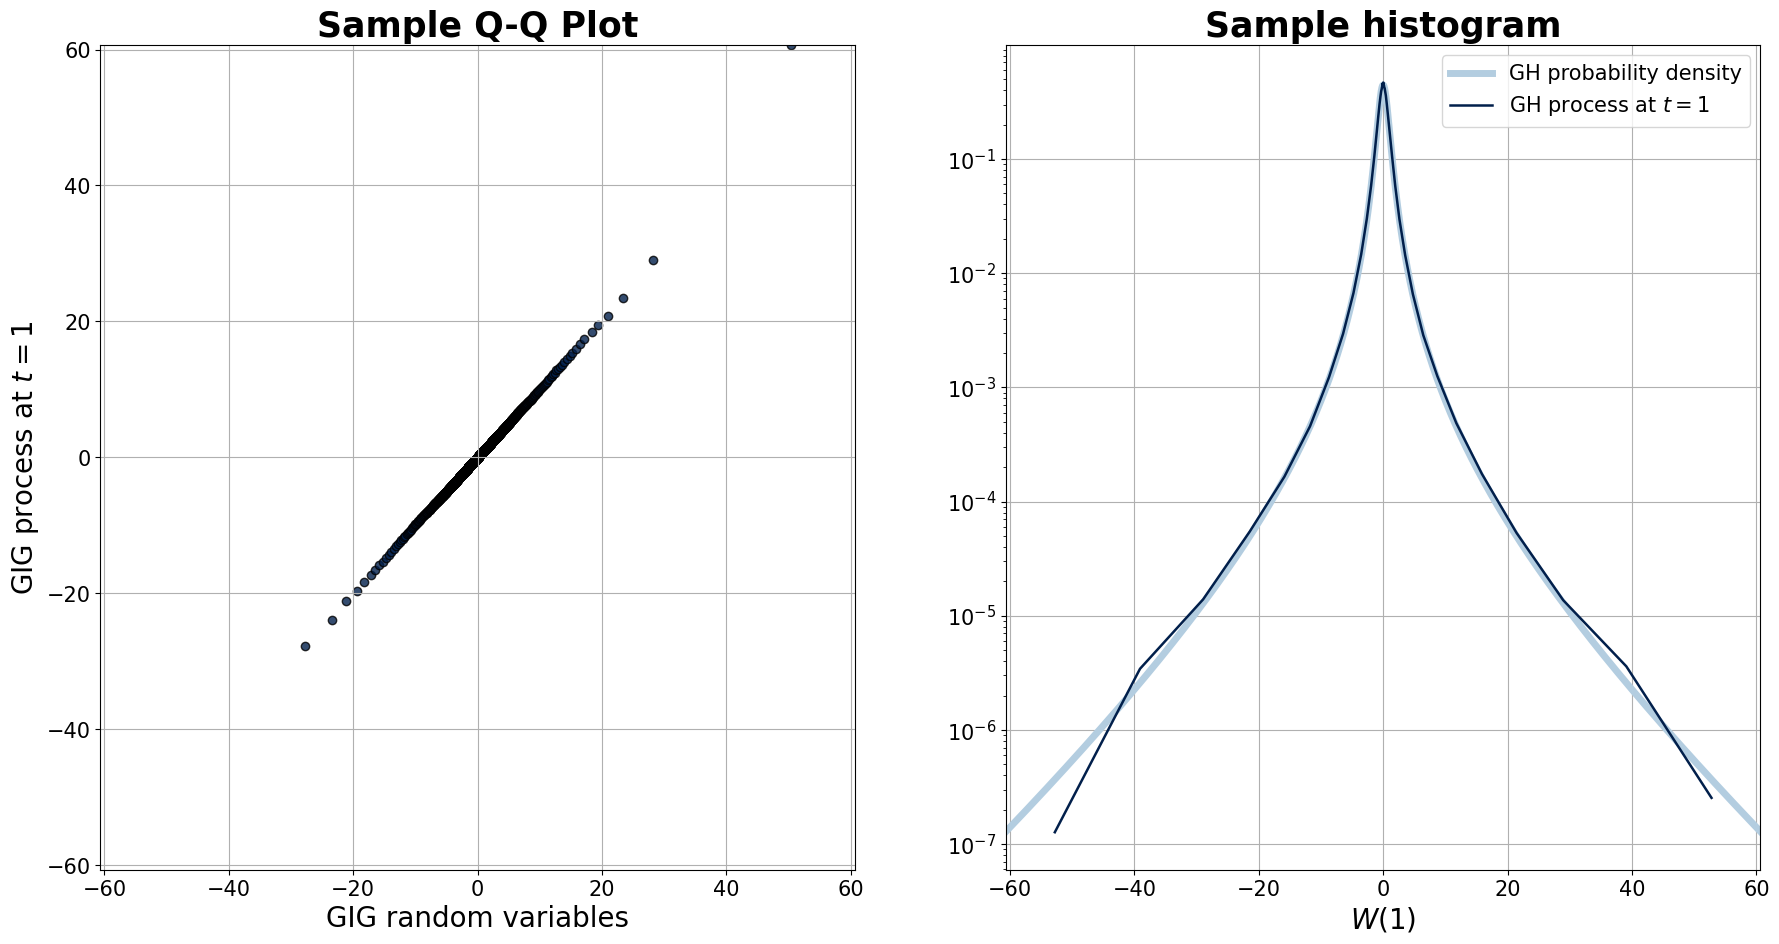

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(21.42, 10.71))

qqplot(x=samples_rv_sampler, y=point_process_samples, c='#011f4b', alpha=0.8, edgecolor='k', ax=ax[0], quantiles=10000)
ax[0].grid(True)
ax[0].set_title(r'Sample Q-Q Plot', fontsize=25, weight="bold")
ax[0].set_xlabel('GIG random variables', fontsize=20)
ax[0].set_ylabel(r'GIG process at $t=1$',fontsize=20)

ax[0].set_xlim(range_min, range_max)
ax[0].set_ylim(range_min, range_max)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)

nb_bins = 30
center_eps = 0.01
#bin_space = np.linspace(range_min, range_max, nb_bins)
bin_space = np.sort(np.concatenate((np.logspace(start=np.log10(center_eps), stop=np.log10(range_max), num=nb_bins), -np.logspace(start=np.log10(center_eps), stop=np.log10(range_max), num=nb_bins))))
special_idx = int(bin_space.size/2)
bin_space = np.delete(bin_space, [special_idx-1, special_idx])
bin_space = np.insert(bin_space, obj=special_idx-1, values=0)


counts, bin_edges = np.histogram(point_process_samples, density=True, bins=bin_space)
bin_centers = moving_average(bin_edges, n=2)

ax[1].plot(gh_range, gh_density, lw=5, label='GH probability density', c='#b3cde0')
ax[1].plot(bin_centers, counts, label=r'GH process at $t=1$', c='#011f4b', lw=1.8)

ax[1].grid(True)

ax[1].set_xlabel(r'$W(1)$', fontsize=20)
ax[1].set_title('Sample histogram', fontsize=25, weight="bold")
ax[1].legend(fontsize=15)


ax[1].set_xlim(range_min, range_max)
ax[1].set_yscale('log')

ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)

#plt.savefig('marginal_distribution_plots/marginal_stats_lam_{}_delta_{}_gamma_{}_beta_{}.jpg'.format(lam, delta, gamma, beta), dpi=200)
plt.show()